In [1]:
from phantominator import shepp_logan
from matplotlib import pyplot as plt

import torch

from loguru import logger
import pathlib
from natsort import natsorted, ns

import pandas as pd

from transformers import AutoModelForCausalLM

import csv

/home/nsagan/experiments/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### TODO
- Our quantization implementations
- Lower the bits for Q and increase the dimension of the factors
- Run inference with our results

### Notes
- Preventing Diverging LoftQ optimization w/ "momentum":
$B_{k+1} = Q((1-\alpha) B_k + \alpha * B_k)$
- Question: does NF work or not; convergence issue
- Try sketching
- Can rotate $L$ and $R$ with some unitary matrix $H$ that makes the data more NF-quantizable (more Gaussian)
- Add F-norm regularization on $L$, $R$
- Some normalize and shift
- Sparse $Q$
- Make $Q$ have a Kronecker structure ($\exist$ papers on this)
- Replace $Q$ with $QD$, where $D$ is full-precision and diagonal
- Try changing the objective function (type of norm)?
- Use data-aware oprimization: right-multiply by a batch of training data (see: GPTQ)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../../src')
sys.path.insert(0,'../../peft/src')


from quantization import *
from weight_compressors import *
from hyperparameter_sweeps import *
from benchmarkers import *
from peft_additions import *

In [4]:
DEFAULT_DEVICE = "cuda:2"

In [5]:
mistral = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


In [6]:
layer_name, X_mis = list(mistral.named_parameters())[2]
X_mis = X_mis.detach().to(DEFAULT_DEVICE)

torch.Size([1024, 4096])


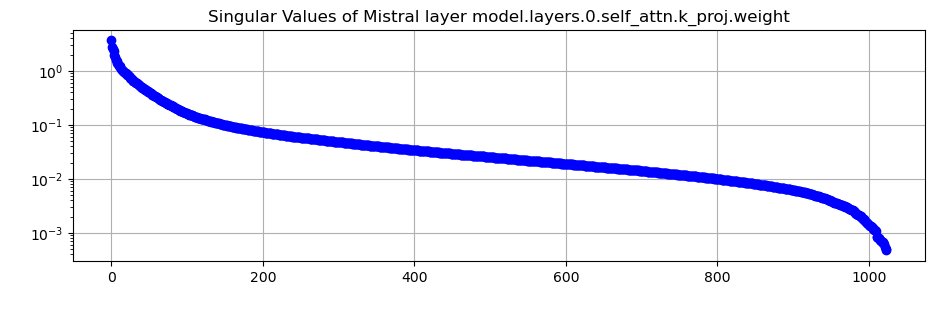

In [7]:
print(X_mis.shape)
_, S, _ = torch.linalg.svd(X_mis.float(), full_matrices=False)

# Plot the singular values
plt.figure(figsize=(11, 3))
plt.plot(S.cpu(), marker='o', linestyle='-', color='b')
plt.title(f'Singular Values of Mistral layer {layer_name}')
plt.xlabel('Index', color="white")
plt.ylabel('Singular Value', color="white")
plt.yscale('log')
plt.grid(True)
plt.show()

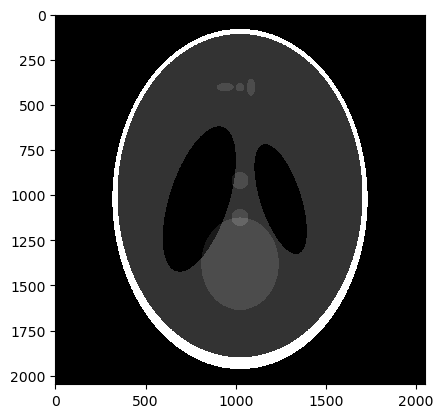

In [8]:
# Generate a phantominator matrix
X = torch.Tensor(shepp_logan(2048))
plt.imshow(X, cmap="gray", interpolation="nearest")
plt.show()

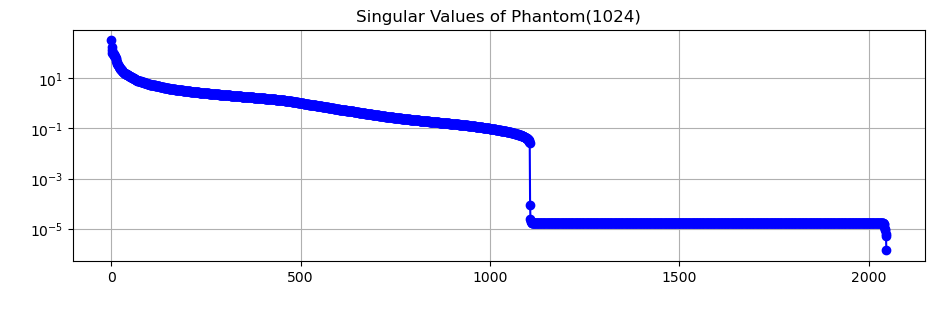

In [9]:
_, S, _ = torch.linalg.svd(X.float(), full_matrices=False)

# Plot the singular values
plt.figure(figsize=(11, 3))
plt.plot(S, marker='o', linestyle='-', color='b')
plt.title('Singular Values of Phantom(1024)')
plt.xlabel('Index', color="white")
plt.ylabel('Singular Value', color="white")
plt.yscale('log')
plt.grid(True)
plt.show()

In [10]:
def test_iterative_weight_compression(
    X = None,
    algorithm_kwargs = [{
        "k": 64, "r1": 0, "r2": 0,
        "B1": 8, "B2": 8
    }], # list of dictionaries
    algorithm_types = [AlgorithmType.ALTERNATING_MIXED_LPLR],
    plot_title = "Frobenius Norm Errors over Iterations"
):
    plot_colors = ["b", "r", "g", "c", "m", "k"]
    plot_markers = ["o", "X", "*"]
    # Set random seed for reproducibility
    torch.manual_seed(42)

    plt.figure(figsize=(11, 3))
    for i, param_set in enumerate(algorithm_kwargs):
        kwargs = param_set.copy()
        kwargs["log_errors"] = True

        if algorithm_types[i] == AlgorithmType.ALTERNATING_MIXED_LPLR:
            kwargs["X"] = X
            _, _, errors = alternating_mixed_lplr(**kwargs)
        elif algorithm_types[i] == AlgorithmType.DIRECT_SVD_LPLR:
            kwargs["X"] = X
            _, _, errors = direct_svd_mixed_lplr(**kwargs)
        elif algorithm_types[i] == AlgorithmType.LOFTQ:
            kwargs["weight"] = X
            _, _, _, errors = loftq_init(**kwargs)
        else: ## Loftq-LPLR
            kwargs["weight"] = X
            _, _, _, errors = loftq_lplr_init(**kwargs)

        fro_norm_X = torch.norm(X, p="fro").item()
        relative_errors = np.array(errors) / fro_norm_X

        print(relative_errors)

        # Plot errors over iterations
        plt.plot(
            range(1, len(relative_errors) + 1),
            relative_errors,
            marker=plot_markers[(i // len(plot_colors)) % len(plot_markers)],
            linestyle="-",
            markersize=4,
            color=plot_colors[i % len(plot_colors)],
            label=f"Param Set {i+1}*")

    print("-"*80, "\n* Legend Key")
    for i, kwargs in enumerate(algorithm_kwargs):
        print(f"Param Set {i+1}: ", kwargs)
        print("\tusing algorithm type ", algorithm_types[i])

    plt.title(plot_title)
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


[0.0908358  0.08569044 0.08261828 0.08069003 0.0793516  0.0783509
 0.0775663  0.07692224 0.07640115 0.07595317 0.07556579 0.07522112
 0.0749204  0.07465968 0.07441503 0.0741986  0.07398087 0.07378988
 0.07362305 0.07346059 0.0733058  0.07316421 0.07303565 0.07290998
 0.07279814 0.07267905 0.07257449 0.07247593 0.07238837 0.07231067
 0.0722319  0.07216294 0.07209092 0.0720196  0.07195284 0.07188858
 0.07183343 0.07177623 0.07172037 0.07167104 0.07162675 0.07158161
 0.07153981 0.07149797 0.07145275 0.07141959 0.07138132 0.0713447
 0.07131108 0.07127398 0.07123206 0.07119582 0.07116214 0.0711308
 0.07109721 0.07106471 0.07103523 0.07100761 0.07098302 0.070958
 0.07093666 0.07091182 0.07089029 0.07086736 0.07084545 0.0708273
 0.07080993 0.07079176 0.07077566 0.07075912 0.07074215 0.07072479
 0.0707135  0.07070196 0.07068925 0.07067578 0.07066488 0.07065117
 0.07063802 0.07062419 0.070612   0.07059706 0.0705849  0.07057235
 0.07056204 0.07055171 0.07054208 0.07052826 0.07051767 0.07050831
 

100%|██████████| 100/100 [00:34<00:00,  2.91it/s]

[0.09086726 0.08577207 0.08272723 0.08082187 0.07949959 0.07849679
 0.0777303  0.07708447 0.07656067 0.07609689 0.0756899  0.07533002
 0.07501689 0.07473046 0.0744733  0.07424811 0.07403257 0.07381869
 0.07364975 0.07347622 0.07332306 0.07316322 0.07304229 0.07292182
 0.07282117 0.0727134  0.07260387 0.07249474 0.07242243 0.07233249
 0.07224413 0.07216369 0.07209866 0.0720183  0.07194028 0.07190732
 0.07180162 0.07172216 0.07167689 0.07161591 0.07156372 0.07150953
 0.07143813 0.07138715 0.07138295 0.07130396 0.07127126 0.07122715
 0.07127963 0.07114073 0.07110536 0.07106945 0.07104694 0.07096699
 0.07093501 0.07084157 0.07079866 0.07074006 0.07071415 0.07066163
 0.07066484 0.0706189  0.07058582 0.07056172 0.0705262  0.07051357
 0.07045311 0.07043897 0.07041631 0.07037922 0.07034357 0.07034078
 0.07030124 0.07026717 0.07023807 0.07023281 0.07020916 0.07016965
 0.07016635 0.07014336 0.07012696 0.07011237 0.07009599 0.07006798
 0.07008825 0.07002168 0.07002563 0.0699726  0.06996102 0.0699

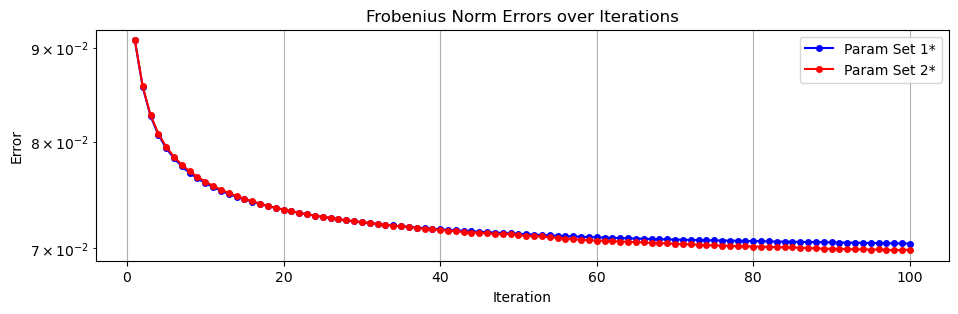

In [18]:
test_iterative_weight_compression(
    algorithm_kwargs = [{
        "num_bits": 4, "reduced_rank": 64, "num_iter": 100, "quant_type": QuantType.UNIFORM
    },
    {
        "num_bits": 4, "num_bits_factors": 8, "reduced_rank": 64,
        "num_iter": 100, "num_iter_lplr": 50, "quant_type": QuantType.UNIFORM
    }],
    algorithm_types=[
        AlgorithmType.LOFTQ, AlgorithmType.LOFTQ_LPLR
    ],
    plot_title="Frobenius Norm Errors over Iterations",
    X=X_mis.T
)

100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


[0.0908358  0.08569044 0.08261828 0.08069003 0.0793516  0.0783509
 0.0775663  0.07692224 0.07640115 0.07595317 0.07556579 0.07522112
 0.0749204  0.07465968 0.07441503 0.0741986  0.07398087 0.07378988
 0.07362305 0.07346059 0.0733058  0.07316421 0.07303565 0.07290998
 0.07279814 0.07267905 0.07257449 0.07247593 0.07238837 0.07231067
 0.0722319  0.07216294 0.07209092 0.0720196  0.07195284 0.07188858
 0.07183343 0.07177623 0.07172037 0.07167104 0.07162675 0.07158161
 0.07153981 0.07149797 0.07145275 0.07141959 0.07138132 0.0713447
 0.07131108 0.07127398 0.07123206 0.07119582 0.07116214 0.0711308
 0.07109721 0.07106471 0.07103523 0.07100761 0.07098302 0.070958
 0.07093666 0.07091182 0.07089029 0.07086736 0.07084545 0.0708273
 0.07080993 0.07079176 0.07077566 0.07075912 0.07074215 0.07072479
 0.0707135  0.07070196 0.07068925 0.07067578 0.07066488 0.07065117
 0.07063802 0.07062419 0.070612   0.07059706 0.0705849  0.07057235
 0.07056204 0.07055171 0.07054208 0.07052826 0.07051767 0.07050831
 

100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


[0.09187493 0.08733586 0.08466706 0.08299872 0.08189943 0.08102624
 0.08037261 0.07987232 0.0794279  0.07901698 0.07878521 0.07834523
 0.07799991 0.07796778 0.07767911 0.07742108 0.0770374  0.07694197
 0.07689688 0.07694451 0.07647862 0.07639116 0.07660717 0.07630713
 0.07620779 0.07633798 0.07613061 0.07625306 0.07599795 0.07602025
 0.07570827 0.0762878  0.07590749 0.07588387 0.07542838 0.0756856
 0.07561709 0.07568063 0.0756335  0.07547519 0.07580334 0.07565383
 0.07570309 0.07562655 0.07547511 0.07551685 0.07572806 0.07578395
 0.07586676 0.0754902  0.07563585 0.0756484  0.07543837 0.07575542
 0.07554027 0.07568021 0.07569271 0.07571999 0.07578616 0.07608474
 0.07608355 0.0761455  0.07601207 0.07610857 0.07604327 0.07614555
 0.07617286 0.07619223 0.07616181 0.07621161 0.07620581 0.07627808
 0.07630424 0.07683311 0.076548   0.0765635  0.0762522  0.07630001
 0.07657369 0.07629429 0.07652726 0.07646912 0.07669151 0.07640767
 0.07664303 0.07664664 0.07664068 0.07675799 0.07663147 0.07654

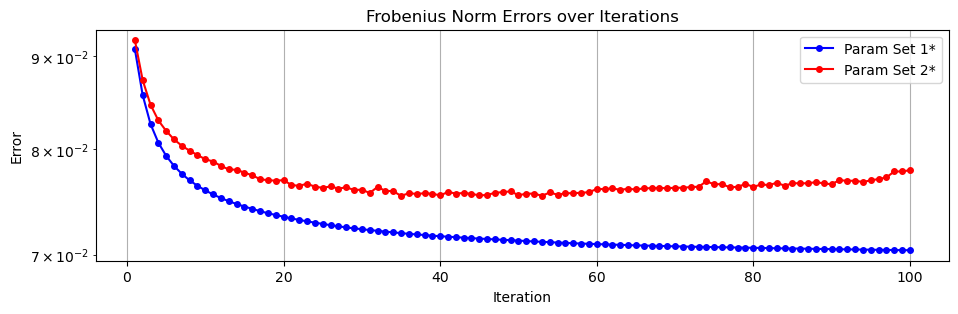

In [20]:
test_iterative_weight_compression(
    algorithm_kwargs = [{
        "num_bits": 4, "reduced_rank": 64, "num_iter": 100, "quant_type": QuantType.UNIFORM
    },
    {
        "num_bits": 4, "num_bits_factors": 4, "reduced_rank": 64,
        "num_iter": 100, "num_iter_lplr": 50, "quant_type": QuantType.UNIFORM
    }],
    algorithm_types=[
        AlgorithmType.LOFTQ, AlgorithmType.LOFTQ_LPLR
    ],
    plot_title="Frobenius Norm Errors over Iterations",
    X=X_mis.T
)

100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[0.08097707 0.07655463 0.07443008 0.07322451 0.07244457 0.07193358
 0.07159784 0.07136988 0.0712131  0.0711059  0.07104702 0.07102698
 0.07102541 0.07104771 0.07106786 0.07112504 0.07117758 0.07124499
 0.07134293 0.07146993]


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]

[0.08097765 0.07655683 0.07443776 0.07323711 0.07246157 0.07194614
 0.07159805 0.07136365 0.07120007 0.07109538 0.07105815 0.07103959
 0.07102903 0.0710559  0.07110185 0.07114992 0.07120294 0.07128103
 0.07137682 0.07147994]
-------------------------------------------------------------------------------- 
* Legend Key
Param Set 1:  {'num_bits': 4, 'reduced_rank': 64, 'num_iter': 20}
	using algorithm type  AlgorithmType.LOFTQ
Param Set 2:  {'num_bits': 4, 'num_bits_factors': 8, 'reduced_rank': 64, 'num_iter': 20, 'num_iter_lplr': 50}
	using algorithm type  AlgorithmType.LOFTQ_LPLR


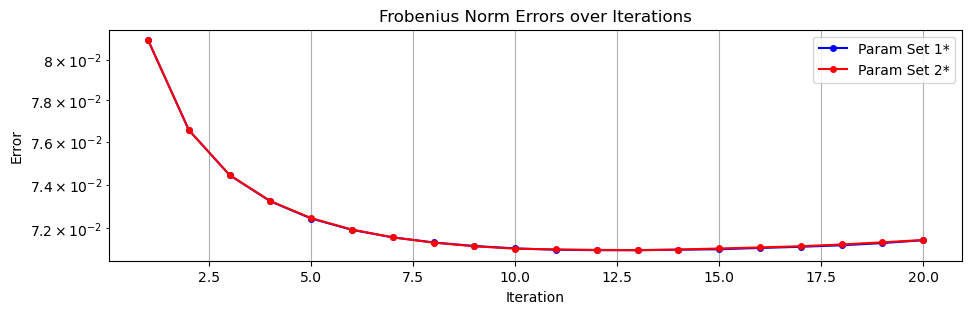

In [19]:
test_iterative_weight_compression(
    algorithm_kwargs = [{
        "num_bits": 4, "reduced_rank": 64, "num_iter": 20
    },
    {
        "num_bits": 4, "num_bits_factors": 8, "reduced_rank": 64,
        "num_iter": 20, "num_iter_lplr": 50
    }],
    algorithm_types=[
        AlgorithmType.LOFTQ, AlgorithmType.LOFTQ_LPLR
    ],
    plot_title="Frobenius Norm Errors over Iterations",
    X=X_mis.T
)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[0.40465212 0.38503885 0.38211827 0.38379331 0.38737399 0.39203849
 0.39722905 0.40271519 0.40860573 0.4148006  0.42132363 0.42799507
 0.43501459 0.44232229 0.45009218 0.45799651 0.46661223 0.47594003
 0.48604424 0.49690513]


100%|██████████| 20/20 [00:01<00:00, 10.92it/s]


[0.53717307 0.50295411 0.50047966 0.50766518 0.51911203 0.53340267
 0.55012276 0.56907983 0.59100987 0.61623915 0.64458644 0.67621471
 0.71147387 0.75236114 0.79682067 0.84474274 0.90159992 0.96472562
 1.03373415 1.11072524]
-------------------------------------------------------------------------------- 
* Legend Key
Param Set 1:  {'num_bits': 2, 'reduced_rank': 64, 'num_iter': 20, 'quant_type': <QuantType.UNIFORM: 0>}
	using algorithm type  AlgorithmType.LOFTQ
Param Set 2:  {'num_bits': 2, 'reduced_rank': 64, 'num_iter': 20, 'quant_type': <QuantType.OUR_UNIFORM: 2>}
	using algorithm type  AlgorithmType.LOFTQ


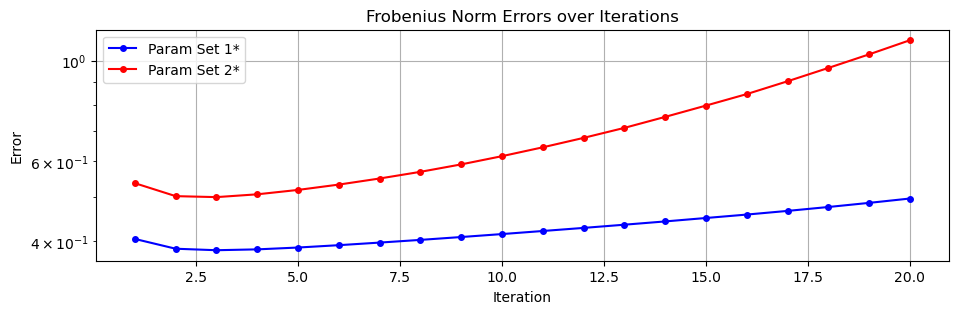

In [18]:
test_iterative_weight_compression(
    algorithm_kwargs = [{
        "num_bits": 2, "reduced_rank": 64, "num_iter": 20, "quant_type": QuantType.UNIFORM
    },
    {
        "num_bits": 2, "reduced_rank": 64, "num_iter": 20, "quant_type": QuantType.OUR_UNIFORM
    }],
    algorithm_types=[
        AlgorithmType.LOFTQ, AlgorithmType.LOFTQ
    ],
    plot_title="Frobenius Norm Errors over Iterations",
    X=X_mis.T
)

In [25]:
### Do some hyperparameter sweeps on the Shepp-Logan matrix
average_bit_level = 3
budget = X.shape[0] * X.shape[1] * average_bit_level

In [13]:
mtxs, alpha, beta, B, error = lplr_sweep_alpha_and_B(
    X=X, budget=budget,
    kwarg_dict={"quant_type": QuantType.NF, "iters":30},
    lplr_type=AlgorithmType.ALTERNATING_MIXED_LPLR,
    debug=True
)

--------------------------------------------------


2024-01-10 20:19:50.463 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=4, alpha=0.0, beta=0.375


2024-01-10 20:19:56.792 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.04914308388491152


--------------------------------------------------


2024-01-10 20:19:56.793 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=4, alpha=0.1, beta=0.28846154
2024-01-10 20:20:01.415 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.016465588878061016


--------------------------------------------------


2024-01-10 20:20:01.416 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=4, alpha=0.2, beta=0.234375
2024-01-10 20:20:05.430 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.023561198042299454


--------------------------------------------------


2024-01-10 20:20:05.431 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=4, alpha=0.3, beta=0.19736842
2024-01-10 20:20:08.836 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.03343556575760792


--------------------------------------------------


2024-01-10 20:20:08.837 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=4, alpha=0.4, beta=0.17045455
2024-01-10 20:20:11.624 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.04170828880907354


--------------------------------------------------


2024-01-10 20:20:11.625 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=4, alpha=0.5, beta=0.15
2024-01-10 20:20:14.273 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.0487068579521333


--------------------------------------------------


2024-01-10 20:20:14.274 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:169 - [B=4]The best frobenius norm error was for alpha=0.1: 0.016465588878061016


--------------------------------------------------


2024-01-10 20:20:14.275 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=8, alpha=0.0, beta=0.1875
2024-01-10 20:20:26.463 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.03577590105845121


--------------------------------------------------


2024-01-10 20:20:26.463 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=8, alpha=0.1, beta=0.17045455
2024-01-10 20:20:37.358 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.04109281755345323


--------------------------------------------------


2024-01-10 20:20:37.359 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=8, alpha=0.2, beta=0.15625
2024-01-10 20:20:46.913 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.046138310693300016


--------------------------------------------------


2024-01-10 20:20:46.914 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=8, alpha=0.3, beta=0.14423077
2024-01-10 20:20:55.263 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.05049681611339997


--------------------------------------------------


2024-01-10 20:20:55.264 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=8, alpha=0.4, beta=0.13392857
2024-01-10 20:21:02.414 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.05449765252624419


--------------------------------------------------


2024-01-10 20:21:02.415 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=8, alpha=0.5, beta=0.125
2024-01-10 20:21:08.398 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.05813137862787287


--------------------------------------------------


2024-01-10 20:21:08.399 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:169 - [B=8]The best frobenius norm error was for alpha=0.0: 0.03577590105845121


--------------------------------------------------


2024-01-10 20:21:08.399 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha_and_B:237 - The best frobenius norm error was for B=4, alpha=0.1: 0.016465588878061016


In [26]:
mtxs, alpha, beta, B, error = lplr_sweep_alpha_and_B(
    X=X, budget=budget,
    kwarg_dict={"quant_type": QuantType.NF, "num_bits": 2, "num_iter": 20, "num_iter_lplr": 20},
    lplr_type=AlgorithmType.LOFTQ_LPLR,
    debug=True
)

--------------------------------------------------


2024-01-10 20:50:16.276 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=4, alpha=0.0, beta=0.125
  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:42<00:00,  2.13s/it]
2024-01-10 20:50:58.984 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.009125714712363231


--------------------------------------------------


2024-01-10 20:50:58.986 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=4, alpha=0.1, beta=0.09615385
100%|██████████| 20/20 [00:35<00:00,  1.78s/it]
2024-01-10 20:51:34.588 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.006779561985307598


--------------------------------------------------


2024-01-10 20:51:34.589 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=4, alpha=0.2, beta=0.078125
100%|██████████| 20/20 [00:31<00:00,  1.60s/it]
2024-01-10 20:52:06.541 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.007494921200351933


--------------------------------------------------


2024-01-10 20:52:06.542 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=4, alpha=0.3, beta=0.06578947
100%|██████████| 20/20 [00:30<00:00,  1.50s/it]
2024-01-10 20:52:36.628 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.008326743893643504


--------------------------------------------------


2024-01-10 20:52:36.629 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=4, alpha=0.4, beta=0.05681818
100%|██████████| 20/20 [00:28<00:00,  1.40s/it]
2024-01-10 20:53:04.663 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.009071508247742228


--------------------------------------------------


2024-01-10 20:53:04.664 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=4, alpha=0.5, beta=0.05
100%|██████████| 20/20 [00:26<00:00,  1.35s/it]
2024-01-10 20:53:31.662 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.009796522185443643


--------------------------------------------------


2024-01-10 20:53:31.663 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:169 - [B=4]The best frobenius norm error was for alpha=0.1: 0.006779561985307598


--------------------------------------------------


2024-01-10 20:53:31.664 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=8, alpha=0.0, beta=0.0625
100%|██████████| 20/20 [01:15<00:00,  3.78s/it]
2024-01-10 20:54:47.309 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.008438204046139595


--------------------------------------------------


2024-01-10 20:54:47.310 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=8, alpha=0.1, beta=0.05681818
100%|██████████| 20/20 [01:07<00:00,  3.37s/it]
2024-01-10 20:55:54.777 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.008948054247131954


--------------------------------------------------


2024-01-10 20:55:54.778 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=8, alpha=0.2, beta=0.05208333
100%|██████████| 20/20 [00:57<00:00,  2.90s/it]
2024-01-10 20:56:52.780 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.009477258178995966


--------------------------------------------------


2024-01-10 20:56:52.781 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=8, alpha=0.3, beta=0.04807692
100%|██████████| 20/20 [00:51<00:00,  2.59s/it]
2024-01-10 20:57:44.628 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.00991594808481359


--------------------------------------------------


2024-01-10 20:57:44.629 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=8, alpha=0.4, beta=0.04464286
100%|██████████| 20/20 [00:45<00:00,  2.28s/it]
2024-01-10 20:58:30.315 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.010366063664465179


--------------------------------------------------


2024-01-10 20:58:30.316 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:140 - B=8, alpha=0.5, beta=0.04166667
100%|██████████| 20/20 [00:41<00:00,  2.06s/it]
2024-01-10 20:59:11.594 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:156 - Frobenius norm error: 0.010793180906087782


--------------------------------------------------


2024-01-10 20:59:11.595 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:169 - [B=8]The best frobenius norm error was for alpha=0.0: 0.008438204046139595


--------------------------------------------------


2024-01-10 20:59:11.596 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha_and_B:237 - The best frobenius norm error was for B=4, alpha=0.1: 0.006779561985307598


In [2]:
class BenchmarkerComparison():
    def __init__(
        self,
        benchmarkers: list[WeightCompressionBenchmarker] = [],
        enforce_budget = True,
        average_bit_level = 4,
        save_to_csv = False,
        continue_csv = False,
        save_file = None,
        reset_error_lists = True
    ):
        if reset_error_lists:
            for benchmarker in benchmarkers:
                benchmarker.reset_errors()

        self.benchmarkers = benchmarkers
        self.save_to_csv = save_to_csv or continue_csv
        self.continue_csv = continue_csv
        self.save_file = save_file
        self.enforce_budget = enforce_budget
        self.average_bit_level = average_bit_level if enforce_budget else 256
        
        if save_to_csv and not continue_csv:
            with open(save_file, 'w') as csvfile:
                writer = csv.writer(csvfile)

                first_headers = ["Layer Name", "n", "d"]
                if enforce_budget:
                    first_headers.append("Bit Budget")
                writer.writerow(first_headers + [benchmarker.label for benchmarker in benchmarkers])
        if continue_csv:
            df = pd.read_csv(save_file)
            self.prev_layer_names = df["Layer Name"]
    
    def write_latest_data(self, layer_name, n, d, budget=0):
        with open(self.save_file, 'a') as csvfile:
            writer = csv.writer(csvfile)
            first_items = [layer_name, n, d]
            if self.enforce_budget:
                first_items.append(budget)
            writer.writerow(first_items + [benchmarker.errors[-1] for benchmarker in self.benchmarkers])
    
    def run_on_matrix(self, layer_name, X):
        if self.continue_csv and layer_name in self.prev_layer_names:
            return
        print(f"Benchmarking {layer_name}")
        n, d = X.size()
        budget = n*d*self.average_bit_level

        for benchmarker in self.benchmarkers:
            benchmarker.run(X, budget)

        if self.save_to_csv:
            self.write_latest_data(layer_name, n, d, budget)

    def print_errors(self):
        for benchmarker in self.benchmarkers:
            print(f"{benchmarker.label}: {benchmarker.errors}")

    def plot_errors(self):
        plot_colors = ["b", "r", "g", "c", "m", "k"]
        plot_markers = ["o", "X", "*"]

        plt.figure(15, 4)
        for i, benchmarker in enumerate(self.benchmarkers):
            plt.plot(
                benchmarker.errors,
                marker=plot_markers[(i // len(plot_colors)) % len(plot_markers)],
                linestyle="-",
                markersize=4,
                color=plot_colors[i % len(plot_colors)],
                label=benchmarker.label
            )
        plt.title("Relative Frobenius Error")
        plt.xlabel("Layer")
        plt.ylabel("Error")
        plt.yscale("log")
        plt.grid(True)
        plt.legend()
        plt.show()


NameError: name 'WeightCompressionBenchmarker' is not defined

In [69]:
class BenchmarkerComparisonList(BenchmarkerComparison):
    def __init__(
        self,
        X_list: list[torch.Tensor] = [],
        **kwargs
    ):
        self.X_list = X_list
        super().__init__(**kwargs)

    def run(self):
        for i, X in enumerate(self.X_list):
            self.run_on_matrix(f"Matrix {i}", X)

In [70]:
class BenchmarkerComparisonModel(BenchmarkerComparison):
    def __init__(
        self,
        model,
        device = "cpu",
        layer_limit:int = -1, # Limits the number of weight matrices used
                              # for benchmarking (mainly for debugging purposes).
                              # -1 means no limit.
         max_num_cols:int = -1, # Excludes weight matrices that are too large.
        **kwargs
    ):
        self.model = model
        self.device = device
        self.layer_limit = layer_limit if layer_limit > 0 else float('inf')
        self.max_num_cols = max_num_cols if max_num_cols > 0 else float('inf')
        super().__init__(**kwargs)

    def run(self):
        layer_count = 0
        for layer_name, X in self.model.named_parameters():
            if self.continue_csv and layer_name in self.prev_layer_names:
                continue
            if X.dim() != 2:
                continue
            if X.shape[0] < X.shape[1]:
                X = X.T
            if X.shape[0] > self.max_num_cols:
                logger.info("Layer larger than maximum size specified, skipping.")
                continue

            layer_count += 1
            if layer_count > self.layer_limit:
                logger.info("Reached layer limit, exiting.")
                return layer_count
            
            self.run_on_matrix(layer_name, X.float().to(self.device))
            

In [71]:
benchmarkers = [
        LoftqBenchmarker(
            {
                "num_iter": 20,
                "reduced_rank": 64,
                "num_bits": 2,
            },
            fixed_rank=True,
            label="LoftQ (2B)"
        ),
        LoftqBenchmarker(
            {
                "num_iter": 20,
                "reduced_rank": 64,
                "num_bits": 4,
            },
            fixed_rank=True,
            label="LoftQ (4B)"
        ),
        # LoftqBenchmarker(
        #     {
        #         "num_iter": 5,
        #         "reduced_rank": 64,
        #         "num_bits": 8,
        #     },
        #     label="LoftQ (8B)"
        # ),
        LplrBenchmarker(
            AlgorithmType.LOFTQ_LPLR,
            {
                "quant_type": QuantType.NF,
                "num_bits": 2,
                "num_bits_factors": 8,
                "reduced_rank": 64,
                "num_iter": 20,
                "num_iter_lplr": 30
            },
            label="Loftq-LPLR (2B)",
            run_hyper_parameter_sweep=False
        ),
        LplrBenchmarker(
            AlgorithmType.LOFTQ_LPLR,
            {
                "quant_type": QuantType.NF,
                "num_bits": 4,
                "num_bits_factors": 8,
                "reduced_rank": 64,
                "num_iter": 20,
                "num_iter_lplr": 30
            },
            label="Loftq-LPLR (4B)",
            run_hyper_parameter_sweep=False
        ),
        # LplrBenchmarker(
        #     AlgorithmType.LOFTQ_LPLR,
        #     {
        #         "quant_type": QuantType.NF,
        #         "num_bits": 8,
        #         "num_bits_factors": 8,
        #         "reduced_rank": 64,
        #         "num_iter": 30,
        #         "num_iter_lplr": 30
        #     },
        #     label="Loftq-LPLR (8B)",
        #     run_hyper_parameter_sweep=False
        # )
    ]

In [72]:
## For debugging, we set limits on how many layers we use
## and their sizes
comparison_object = BenchmarkerComparisonModel(
    model=mistral,
    device=DEFAULT_DEVICE,
    # layer_limit=5,
    max_num_cols=15000,
    benchmarkers=benchmarkers,
    enforce_budget=False,
    save_to_csv=True,
    save_file="/home/nsagan/experiments/results/Loftq_LPLR_comparsion.csv"
)

In [73]:
comparison_object.run()

2024-01-10 22:56:06.826 | INFO     | __main__:run:26 - Layer larger than maximum size specified, skipping.


Benchmarking model.layers.0.self_attn.q_proj.weight


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.0.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Benchmarking model.layers.0.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Benchmarking model.layers.0.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.15s/it]


Benchmarking model.layers.0.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.0.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


Benchmarking model.layers.0.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.96s/it]


Benchmarking model.layers.1.self_attn.q_proj.weight


100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


Benchmarking model.layers.1.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Benchmarking model.layers.1.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.1.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.1.mlp.gate_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.91s/it]


Benchmarking model.layers.1.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.89s/it]


Benchmarking model.layers.1.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.97s/it]


Benchmarking model.layers.2.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.15s/it]


Benchmarking model.layers.2.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.2.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Benchmarking model.layers.2.self_attn.o_proj.weight


100%|██████████| 20/20 [01:23<00:00,  4.15s/it]


Benchmarking model.layers.2.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.2.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.89s/it]


Benchmarking model.layers.2.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.97s/it]


Benchmarking model.layers.3.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.3.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Benchmarking model.layers.3.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.3.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.3.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


Benchmarking model.layers.3.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.3.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.96s/it]


Benchmarking model.layers.4.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.15s/it]


Benchmarking model.layers.4.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Benchmarking model.layers.4.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Benchmarking model.layers.4.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.4.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.4.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


Benchmarking model.layers.4.mlp.down_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.95s/it]


Benchmarking model.layers.5.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.5.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Benchmarking model.layers.5.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.5.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.5.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.90s/it]


Benchmarking model.layers.5.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.90s/it]


Benchmarking model.layers.5.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.95s/it]


Benchmarking model.layers.6.self_attn.q_proj.weight


100%|██████████| 20/20 [01:23<00:00,  4.15s/it]


Benchmarking model.layers.6.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Benchmarking model.layers.6.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


Benchmarking model.layers.6.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.13s/it]


Benchmarking model.layers.6.mlp.gate_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.91s/it]


Benchmarking model.layers.6.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.6.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.96s/it]


Benchmarking model.layers.7.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.7.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Benchmarking model.layers.7.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.7.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.7.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.89s/it]


Benchmarking model.layers.7.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.7.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.95s/it]


Benchmarking model.layers.8.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.8.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


Benchmarking model.layers.8.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.04it/s]


Benchmarking model.layers.8.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.8.mlp.gate_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.92s/it]


Benchmarking model.layers.8.mlp.up_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.90s/it]


Benchmarking model.layers.8.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.96s/it]


Benchmarking model.layers.9.self_attn.q_proj.weight


100%|██████████| 20/20 [01:23<00:00,  4.16s/it]


Benchmarking model.layers.9.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Benchmarking model.layers.9.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Benchmarking model.layers.9.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.13s/it]


Benchmarking model.layers.9.mlp.gate_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.92s/it]


Benchmarking model.layers.9.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.9.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.98s/it]


Benchmarking model.layers.10.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.15s/it]


Benchmarking model.layers.10.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.10.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Benchmarking model.layers.10.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.10.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.86s/it]


Benchmarking model.layers.10.mlp.up_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.90s/it]


Benchmarking model.layers.10.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.96s/it]


Benchmarking model.layers.11.self_attn.q_proj.weight


100%|██████████| 20/20 [01:23<00:00,  4.17s/it]


Benchmarking model.layers.11.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Benchmarking model.layers.11.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Benchmarking model.layers.11.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.13s/it]


Benchmarking model.layers.11.mlp.gate_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.90s/it]


Benchmarking model.layers.11.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


Benchmarking model.layers.11.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.97s/it]


Benchmarking model.layers.12.self_attn.q_proj.weight


100%|██████████| 20/20 [01:23<00:00,  4.15s/it]


Benchmarking model.layers.12.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Benchmarking model.layers.12.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


Benchmarking model.layers.12.self_attn.o_proj.weight


100%|██████████| 20/20 [01:23<00:00,  4.16s/it]


Benchmarking model.layers.12.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.12.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.89s/it]


Benchmarking model.layers.12.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.95s/it]


Benchmarking model.layers.13.self_attn.q_proj.weight


100%|██████████| 20/20 [01:23<00:00,  4.15s/it]


Benchmarking model.layers.13.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Benchmarking model.layers.13.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


Benchmarking model.layers.13.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.13s/it]


Benchmarking model.layers.13.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.89s/it]


Benchmarking model.layers.13.mlp.up_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.91s/it]


Benchmarking model.layers.13.mlp.down_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.95s/it]


Benchmarking model.layers.14.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.13s/it]


Benchmarking model.layers.14.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.14.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.14.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.15s/it]


Benchmarking model.layers.14.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.90s/it]


Benchmarking model.layers.14.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.14.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.97s/it]


Benchmarking model.layers.15.self_attn.q_proj.weight


100%|██████████| 20/20 [01:23<00:00,  4.15s/it]


Benchmarking model.layers.15.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Benchmarking model.layers.15.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.15.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.15.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.89s/it]


Benchmarking model.layers.15.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.15.mlp.down_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.95s/it]


Benchmarking model.layers.16.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.13s/it]


Benchmarking model.layers.16.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Benchmarking model.layers.16.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


Benchmarking model.layers.16.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.16.mlp.gate_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.90s/it]


Benchmarking model.layers.16.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.16.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.97s/it]


Benchmarking model.layers.17.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.17.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


Benchmarking model.layers.17.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.17.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.15s/it]


Benchmarking model.layers.17.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


Benchmarking model.layers.17.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


Benchmarking model.layers.17.mlp.down_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.95s/it]


Benchmarking model.layers.18.self_attn.q_proj.weight


100%|██████████| 20/20 [01:23<00:00,  4.16s/it]


Benchmarking model.layers.18.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Benchmarking model.layers.18.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.18.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.18.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


Benchmarking model.layers.18.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.18.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.96s/it]


Benchmarking model.layers.19.self_attn.q_proj.weight


100%|██████████| 20/20 [01:23<00:00,  4.15s/it]


Benchmarking model.layers.19.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Benchmarking model.layers.19.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.19.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.19.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.89s/it]


Benchmarking model.layers.19.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.19.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.96s/it]


Benchmarking model.layers.20.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.20.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Benchmarking model.layers.20.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


Benchmarking model.layers.20.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.15s/it]


Benchmarking model.layers.20.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.20.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.86s/it]


Benchmarking model.layers.20.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.96s/it]


Benchmarking model.layers.21.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.15s/it]


Benchmarking model.layers.21.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Benchmarking model.layers.21.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.21.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.21.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.21.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


Benchmarking model.layers.21.mlp.down_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.93s/it]


Benchmarking model.layers.22.self_attn.q_proj.weight


100%|██████████| 20/20 [01:23<00:00,  4.15s/it]


Benchmarking model.layers.22.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.22.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Benchmarking model.layers.22.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.22.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.22.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


Benchmarking model.layers.22.mlp.down_proj.weight


100%|██████████| 20/20 [01:38<00:00,  4.95s/it]


Benchmarking model.layers.23.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.23.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Benchmarking model.layers.23.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


Benchmarking model.layers.23.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.23.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


Benchmarking model.layers.23.mlp.up_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.23.mlp.down_proj.weight


100%|██████████| 20/20 [01:39<00:00,  4.97s/it]


Benchmarking model.layers.24.self_attn.q_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.24.self_attn.k_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Benchmarking model.layers.24.self_attn.v_proj.weight


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


Benchmarking model.layers.24.self_attn.o_proj.weight


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Benchmarking model.layers.24.mlp.gate_proj.weight


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Benchmarking model.layers.24.mlp.up_proj.weight


 90%|█████████ | 18/20 [01:27<00:09,  4.88s/it]

In [56]:
torch.cuda.empty_cache()

In [ ]:
comparison_object.print_errors()

In [ ]:
comparison_object.plot_errors()